Importing Packages

In [1]:
import torch
torch.set_default_dtype(torch.double)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.set_default_device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.optim import Adam
from torch.optim import LBFGS
import torch.nn as nn
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import widgets
from IPython.display import display

import plotly.express as px
import dash
from dash import Dash, dcc, html, Input, Output, State

Helper function to create a grid

In [2]:
def grid(x,y,z,nx,ny,nz):
    grid_arr = list()
    sx,sy,sz = 0,0,0
    if (nx == 1): sx = x
    if (ny == 1): sy = y
    if (nz == 1): sz = z
    xs = torch.linspace(sx,x,nx)
    ys = torch.linspace(sy,y,ny)
    zs = torch.linspace(sz,z,nz)
    for x in xs:
        for y in ys:
            for z in zs:
                grid_arr.append((x.item(),y.item(),z.item()))
    grid_arr = torch.tensor(grid_arr)
    return grid_arr

Physical System to Model: 3D Deformation, Linear Isotropic

Training tensor within region of interest

In [3]:
# Range of x and y to be modelled
x_range, x_int = 10, 10
y_range, y_int = 10e-3, 3
z_range, z_int = 10e-3, 3

train = grid(x_range,y_range,z_range,x_int,y_int,z_int).requires_grad_(True).to(device)

#DBC, Position and Displacment.
# Fixing y & z in place at x = 0
DBC_pos = grid(0,y_range,z_range,1,y_int,z_int)
DBC_disp = grid(0,0,0,1,y_int,z_int)
DBC_pos, DBC_disp = DBC_pos.requires_grad_(True).to(device),DBC_disp.requires_grad_(True).to(device)
DBC = [DBC_pos,DBC_disp]

#NBC, Scalar Traction Force, Normal Vector, and Position.
T_hat = [[(6.0/((10e-3)**2),0,0)],
         [(6.0/((10e-3)**2),0,0)],
         [(6.0/((10e-3)**2),0,0)],
         [(6.0/((10e-3)**2),0,0)],
         [(6.0/((10e-3)**2),0,0)]]

n_hat = [[(1.0,0,0)],
         [(1.0,0,0)],
         [(1.0,0,0)],
         [(1.0,0,0)],
         [(1.0,0,0)]]

T_hat, n_hat = torch.tensor(T_hat).permute(0,2,1),torch.tensor(n_hat)
Sigma_hat = T_hat @ n_hat
Sigma_hat = Sigma_hat.requires_grad_(True).to(device)

T_pos = [grid(5,y_range,z_range,1,y_int,z_int).requires_grad_(True).to(device)]
T_pos.append(grid(x_range,0,z_range,x_int,1,z_int).requires_grad_(True).to(device))
T_pos.append(grid(x_range,y_range,z_range,x_int,1,z_int).requires_grad_(True).to(device))
T_pos.append(grid(x_range,y_range,0,x_int,y_int,1).requires_grad_(True).to(device))
T_pos.append(grid(x_range,y_range,z_range,x_int,y_int,1).requires_grad_(True).to(device))

NBC = [T_pos,Sigma_hat]

# Physical Parameters, E = Youngs Modulus (Pa), v = Poisson's ratio (Typically [-1,0.5]).
# Sclera
p = dict(E=1.2e6, v=0.45)
#Stiffness mat, 2D
C_inv = [[1, -p['v'], -p['v'], 0, 0, 0],
     [-p['v'], 1, -p['v'], 0, 0, 0],
     [-p['v'], -p['v'], 1, 0, 0, 0],
     [0, 0, 0, 1+p['v'], 0, 0],
     [0, 0, 0, 0, 1+p['v'], 0],
     [0, 0, 0, 0, 0, 1+p['v']]]
C_inv = np.array(C_inv)
C_inv = C_inv/p['E']
C = np.linalg.inv(C_inv)
C = torch.tensor(C).to(device).requires_grad_(True)

Solution:

With Force (F), Area (A), Length (L), and Elastic Modulus (E), $\delta = \frac{\sigma L}{E} = \frac{\frac{F}{A} L}{E}$

$F = 6N, A = 100mm^2, L = 10m, E = 1.2 MPa, \delta = 0.5m$

In [4]:
#sol

Plotting

In [5]:
def plot_comp():
    plot_input = train.clone()
    pred = model(plot_input)
    
    _, loss_absolute = loss_fn(model, plot_input)
    pred_plot = pred.cpu().detach().numpy() + plot_input.cpu().detach().numpy()

    plt.scatter(pred_plot[:,0].T,pred_plot[:,1].T,label='Deformed',marker='.')
    plt.xlabel('Position')
    plt.title(f"Deformation, Loss: {loss_absolute:.2E}, Epoch {epoch}")
    plt.show()
    plt.clf()

Creating the Model

In [6]:
# i_num nodes, i_len nodes per layer and Tanh activation fn, wide and shallow (64x4)
i_num = 2
i_len = 64
#params to take and approximate
params_in = 3
params_out = 3

# fn to create model
def pinn(input_size, output_size, num_layers, nodes_per_layer, activation):
    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_size, nodes_per_layer))
    
    # Hidden layers
    for layer in range(num_layers):
        layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
        if layer == 0 and activation==Siren:
            layers.append(activation(l=0))
        else:
            layers.append(activation())
    
    # Output layer
    layers.append(nn.Linear(nodes_per_layer, output_size))
    
    return nn.Sequential(*layers)

# custom trainable Tanh activation fn
class TTanh(nn.Module):
    def __init__(self, features=i_len):
        super().__init__()
        self.features = features
        self.a = nn.Parameter(torch.randn(1, features))
        
    def forward(self, x):
        return torch.tanh(self.a * x)

#custom SIREN activation fn
class Siren(nn.Module):
    def __init__(self, features=i_len, l=1):
        super(Siren, self).__init__()
        self.features = features
        # Learnable parameters for the phase and bias
        if l: w = 1 
        else: w = 30
        n = torch.sqrt(torch.tensor(6.0/features))
        self.a_weight = nn.Parameter((torch.rand(1, features) *2*n - n)*w)
        self.a_bias = nn.Parameter(torch.randn(1, features))

    def forward(self, x):
        # Apply the periodic activation function
        return torch.sin( self.a_weight*x + self.a_bias)

# Model to be trained using only Adam
model = pinn(params_in, params_out, i_num, i_len, TTanh)
model.to(device)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=64, bias=True)
  (2): TTanh()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): TTanh()
  (5): Linear(in_features=64, out_features=3, bias=True)
)

Loss Function has the following components:

Physics Loss:

$\mathcal{L}_{Phy} = \frac{1}{N}\sum[\frac{\partial \sigma_{ij}}{\partial x_{j}}]^2$

NBC Loss:

$\mathcal{L}_{NBC} = \frac{1}{N}\sum[\hat{T}.n^T - \sigma]^2$

DBC Loss:

$\mathcal{L}_{DBC} = \frac{1}{N}\sum[u-\hat{u}]^2$

In [7]:
def Stress(model,input):
    # Strain from displacement field
    pred = model(input)
    
    dux = torch.autograd.grad(pred[:,0], input, torch.ones_like(pred[:,0]), retain_graph=True, create_graph=True)[0]
    duy = torch.autograd.grad(pred[:,1], input, torch.ones_like(pred[:,1]), retain_graph=True, create_graph=True)[0]
    duz = torch.autograd.grad(pred[:,2], input, torch.ones_like(pred[:,2]), retain_graph=True, create_graph=True)[0]
    
    duxdx = dux[:,0]
    duxdy = dux[:,1]
    duxdz = dux[:,2]

    duydx = duy[:,0]
    duydy = duy[:,1]
    duydz = duy[:,2]

    duzdx = duz[:,0]
    duzdy = duz[:,1]
    duzdz = duz[:,2]

    epsilon = torch.stack((duxdx, duydy, duzdz, 0.5*(duxdy + duydx), 0.5*(duxdz + duzdx), 0.5*(duydz + duzdy)))
    
    # Stress from Strain and Constitutive matrix
    sigma_6xn = C @ epsilon

    return sigma_6xn[0,:],sigma_6xn[1,:],sigma_6xn[2,:],sigma_6xn[3,:],sigma_6xn[4,:],sigma_6xn[5,:]

In [8]:
def loss_fn(model, batch):
    # model: model
    # batch: training batch

    # Calulate loss from DBC
    DBC_loss = ((model(DBC[0])-DBC[1])**2).mean()


    #Calculating NBC Loss
    NBC_loss = 0
    for i in range(len(NBC[0])):
        sxx_NBC,syy_NBC,szz_NBC,sxy_NBC,sxz_NBC,syz_NBC = Stress(model,NBC[0][i])
        syx_NBC,szx_NBC,szy_NBC = sxy_NBC.clone(),sxz_NBC.clone(),syz_NBC.clone()

        sigma_1x3_x_NBC = torch.stack((sxx_NBC,syx_NBC,szx_NBC), dim=1)
        sigma_1x3_y_NBC = torch.stack((sxy_NBC,syy_NBC,szy_NBC), dim=1)
        sigma_1x3_z_NBC = torch.stack((sxz_NBC,syz_NBC,szz_NBC), dim=1)
        sigma_3x3_NBC = torch.stack((sigma_1x3_x_NBC, sigma_1x3_y_NBC, sigma_1x3_z_NBC), dim=1)

        #test
        prev_sigma.append(sigma_3x3_NBC.detach())

        #NBC Loss
        NBC_loss += ((sigma_3x3_NBC - NBC[1][i])**2).mean()


    #Physics Loss
    #Stress
    sxx_phy,syy_phy,szz_phy,sxy_phy,sxz_phy,syz_phy = Stress(model,batch)

    #Divergence of Stress
    dsxx = torch.autograd.grad(sxx_phy, batch, torch.ones_like(sxx_phy), retain_graph=True, create_graph=True)[0]
    dsyy = torch.autograd.grad(syy_phy, batch, torch.ones_like(syy_phy), retain_graph=True, create_graph=True)[0]
    dszz = torch.autograd.grad(szz_phy, batch, torch.ones_like(szz_phy), retain_graph=True, create_graph=True)[0]

    dsxy = torch.autograd.grad(sxy_phy, batch, torch.ones_like(sxy_phy), retain_graph=True, create_graph=True)[0]
    dsxz = torch.autograd.grad(sxz_phy, batch, torch.ones_like(sxz_phy), retain_graph=True, create_graph=True)[0]
    dsyz = torch.autograd.grad(syz_phy, batch, torch.ones_like(syz_phy), retain_graph=True, create_graph=True)[0]
    

    dsxxdx = dsxx[:,0]
    dsyydy = dsyy[:,1]
    dszzdz = dszz[:,2]

    dsxydx = dsxy[:,0]
    dsxydy = dsxy[:,1]

    dsxzdx = dsxz[:,0]
    dsxzdz = dsxz[:,2]

    dsyzdy = dsyz[:,1]
    dsyzdz = dsyz[:,2]

    div_stress = torch.stack((dsxxdx + dsxydy + dsxzdz,
                              dsxydx + dsyydy + dsyzdz,
                              dsxzdx + dsyzdy + dszzdz), dim=0)
    
    #test
    prev_div.append(div_stress.detach())
    
    phy_loss = ((div_stress)**2).mean()


    # calculate weighted loss
    DBC_loss_weighted,NBC_loss_weighted = DBC_loss*DBC_weight , NBC_loss*NBC_weight

    obtain_grads([DBC_loss_weighted, NBC_loss_weighted, phy_loss])

    loss_weighted = DBC_loss_weighted + NBC_loss_weighted + phy_loss
    loss_absolute = DBC_loss + NBC_loss + phy_loss

    return loss_weighted, loss_absolute

Loss weights are dynamically updated using:

$\hat{\lambda}^{(n)}_{ic} = \frac{max \{| {\nabla_{\theta}} \mathcal{L}_{physics} |\} } {| \overline{ {\nabla_{\theta}} \mathcal{L}_{ic} } |} $
or
$ \frac{std \{ {\nabla_{\theta}} \mathcal{L}_{physics} \} } {std \{ {\nabla_{\theta}} \mathcal{L}_{ic} \} } $
or
$\frac{|| {\nabla_{\theta}} \mathcal{L}_{physics} ||_{2} } {|| {\nabla_{\theta}} \mathcal{L}_{ic} ||_{2} } $

$\lambda^{(n)}_{ic} = \alpha \lambda^{(n-1)}_{ic} + (1 - \alpha) \hat{\lambda}^{(n)}_{ic}  $

In [9]:
phy_grads, NBC_grads, DBC_grads = list(), list(), list()
list_of_grads = [DBC_grads, NBC_grads, phy_grads]
list_of_losses = list()
NBC_weight, DBC_weight = 1.0, 1.0

def weight_update_max_mean(w_update, a=0.9):
    phy_loss_max = torch.max(torch.abs(torch.stack(phy_grads[-w_update:])))
    
    NBC_loss_mean = torch.mean(torch.abs(torch.stack(NBC_grads[-w_update:])))
    NBC_weight_hat = (phy_loss_max / NBC_loss_mean).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_mean = torch.mean(torch.abs(torch.stack(DBC_grads[-w_update:])))
    DBC_weight_hat = (phy_loss_max / DBC_loss_mean).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def weight_update_std(w_update, a=0.9):
    phy_loss_std = torch.std(torch.stack(phy_grads[-w_update:]))

    NBC_loss_std = torch.std(torch.stack(NBC_grads[-w_update:]))
    NBC_weight_hat = (phy_loss_std / NBC_loss_std).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_std = torch.std(torch.stack(DBC_grads[-w_update:]))
    DBC_weight_hat = (phy_loss_std / DBC_loss_std).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def weight_update_norm(w_update, a=0.9):
    phy_loss_norm = torch.linalg.matrix_norm(torch.stack(phy_grads[-w_update:]))
    
    NBC_loss_norm = torch.linalg.matrix_norm(torch.stack(NBC_grads[-w_update:]))
    NBC_weight_hat = (phy_loss_norm / NBC_loss_norm).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_norm = torch.linalg.matrix_norm(torch.stack(DBC_grads[-w_update:]))
    DBC_weight_hat = (phy_loss_norm / DBC_loss_norm).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def obtain_grads(losses):

    for i in range(len(list_of_grads)):
        optim.zero_grad()
        losses[i].backward(retain_graph=True)
        temp = list()
        for name, param in model.named_parameters():
            if param.grad is not None:
                temp.append(torch.reshape(param.grad,(-1,)))
        list_of_grads[i].append(torch.cat(temp))

    list_of_losses.append([losses[0].item(),losses[1].item(),losses[2].item()])
        
    return

Checkpoint During Training

In [10]:
best_model_adam = {'epoch':-1}
best_model_LBFGS = {'epoch':-1}
best_model = {'epoch':-1}

def checkpoint(best_model):
    if (best_model['epoch'] == -1) or (prev_loss[-1] < best_model['loss']):
        best_model = {
            'epoch': epoch,
            'model_state_dict': copy.deepcopy(copy.deepcopy(model.state_dict())),
            'optimizer_state_dict': copy.deepcopy(copy.deepcopy(optim.state_dict())),
            'loss': prev_loss[-1],
            'model_params':[params_in, params_out, i_num, i_len],
        'p_sigma':prev_sigma[-1],
        'p_div':prev_div[-1]
                    }
    return best_model

def final(model):
    model = {
        'epoch': epoch,
        'model_state_dict': copy.deepcopy(copy.deepcopy(model.state_dict())),
        'optimizer_state_dict': copy.deepcopy(copy.deepcopy(optim.state_dict())),
        'loss': prev_loss[-1],
        'model_params':[params_in, params_out, i_num, i_len],
        'p_sigma':prev_sigma[-1],
        'p_div':prev_div[-1]
                }
    return model

Plot Training Data

In [11]:
def plot_train(t=""):
    plt.plot(np.log10(prev_loss),c='tab:blue',label='Log Loss')
    plt.title(f"Log Loss over {len(prev_loss)} Calls"+t)
    plt.xlabel("Calls")
    plt.ylabel("Log Loss")
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(phy_grads,1)),0)).cpu(),label='log mean phy loss grad',c='tab:green')
    plt.title(f"Gradient of parameters wrt Physics Loss over {len(prev_loss)} Calls"+t)
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(NBC_grads,1)),0)).cpu(),label='log mean NBC loss grad',c='tab:orange')
    plt.title(f"Gradient of parameters wrt NBC Loss over {len(prev_loss)} Calls"+t)
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(DBC_grads,1)),0)).cpu(),label='log mean DBC loss grad',c='tab:red')
    plt.title(f"Gradient of parameters wrt DBC Loss over {len(prev_loss)} Calls"+t)
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

Closure Fn for Optimisers

In [12]:
def closure():
    loss_weighted, loss_absolute = loss_fn(model, train)
    optim.zero_grad()
    loss_weighted.backward()
    prev_loss.append(loss_absolute.item())
    return loss_weighted

Training the model

Finished epoch 0, latest loss 6.18E+10
Finished epoch 1000, latest loss 9.38E+06
Finished epoch 2000, latest loss 1.15E+06
Finished epoch 3000, latest loss 6.40E+05
Finished epoch 4000, latest loss 4.44E+05
Finished epoch 5000, latest loss 2.77E+05
Finished epoch 6000, latest loss 1.65E+05
Finished epoch 7000, latest loss 1.94E+05
Finished epoch 8000, latest loss 3.93E+05
Finished epoch 9000, latest loss 1.64E+05
Finished epoch 10000, latest loss 1.40E+06
Finished epoch 11000, latest loss 6.68E+04
Finished epoch 12000, latest loss 7.96E+05
Finished epoch 13000, latest loss 2.89E+08
Finished epoch 14000, latest loss 6.20E+04


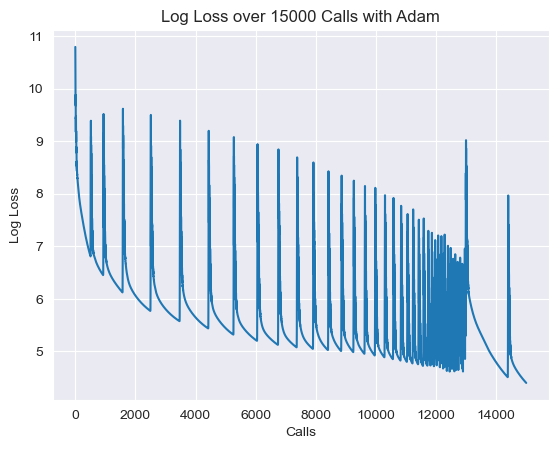

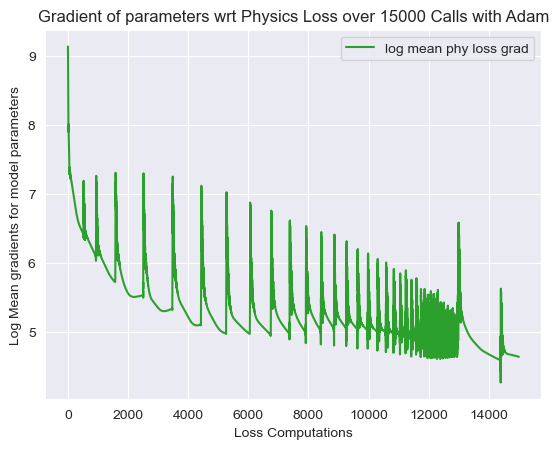

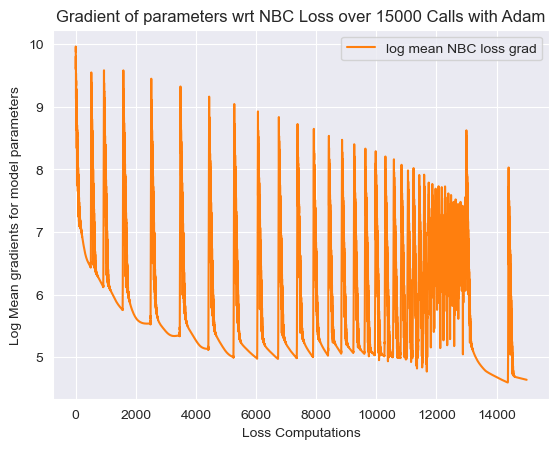

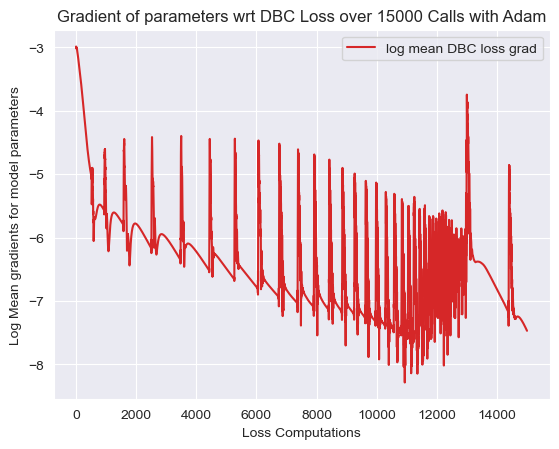

Finished epoch 15000, latest loss 1.70E+04
Finished epoch 15100, latest loss 2.68E+01
Finished epoch 15200, latest loss 7.03E+00
Finished epoch 15300, latest loss 6.31E+98
Finished epoch 15400, latest loss 3.17E+98


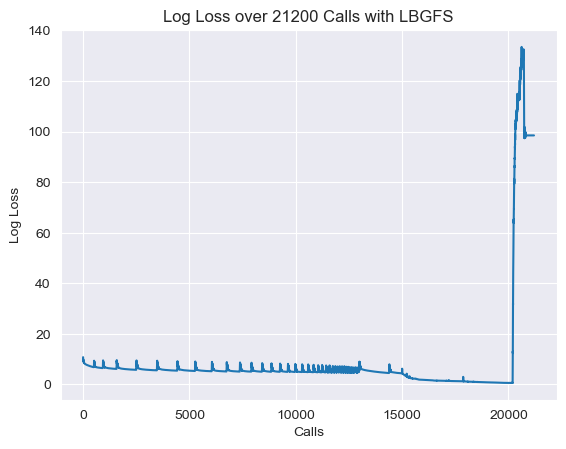

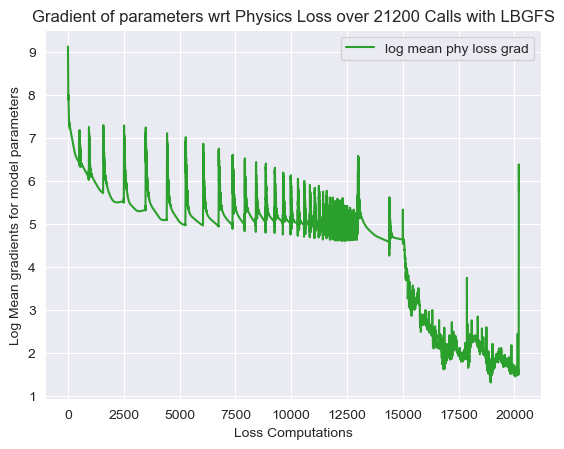

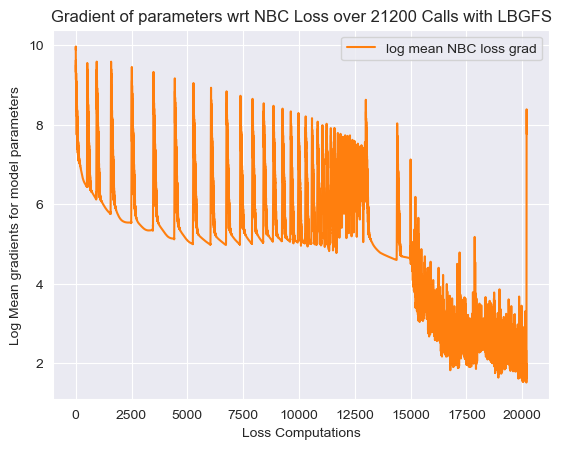

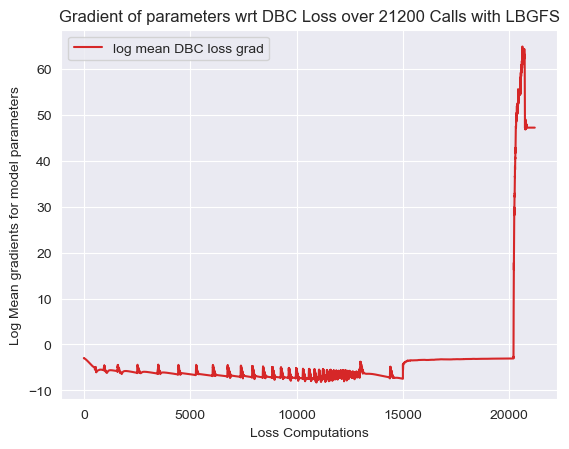

(0,)


<Figure size 640x480 with 0 Axes>

In [13]:
# train
n_epochs = (15000,500)
w_update = 1
epochs = 0
prev_loss = list()
training = True

#test
prev_div, prev_sigma = list(),list()

while (training):
    # start with Adam optimizer
    optim = Adam(model.parameters())
    for epoch in range(n_epochs[0]):
        
        optim.step(closure)
        best_model_adam = checkpoint(best_model_adam)
        best_model = checkpoint(best_model)

        #if not (epoch%w_update): NBC_weight , DBC_weight = weight_update_max_mean(w_update)
        if not (epoch%1000): print(f'Finished epoch {epochs+epoch}, latest loss {prev_loss[-1]:.2E}')
    
    final_model_adam = final(model)
    plot_train(" with Adam")
    epochs += n_epochs[0]

    # continue with LBFGS
    optim = LBFGS(model.parameters())
    for epoch in range(n_epochs[1]):
        optim.step(closure)

        # reset if loss becomes NAN
        if np.isnan(prev_loss[-1]):
            optim = LBFGS(model.parameters())
            model.load_state_dict(best_model_LBFGS['model_state_dict'])
            optim.load_state_dict(best_model_LBFGS['optimizer_state_dict'])
            loss = best_model_LBFGS['loss']

        best_model_LBFGS = checkpoint(best_model_LBFGS)
        best_model = checkpoint(best_model)

        #if not (epoch%w_update): NBC_weight , DBC_weight = weight_update_max_mean(w_update)
        if not (epoch%100): print(f'Finished epoch {epochs+epoch}, latest loss {prev_loss[-1]:.2E}')
    
    final_model_LBGFS = final(model)
    plot_train(" with LBGFS")
    epochs += n_epochs[1]


    # User determines if training should continue
    user_input = input("Enter epochs to continue training (Adam LBGFS) or 0 to stop:")
    try:
        n_epochs = tuple(int(item) for item in user_input.split())
        print(n_epochs)
    except:
        print("Error")
        n_epochs = (0,0)
    if len(n_epochs) != 2: training = False

Plotting best model

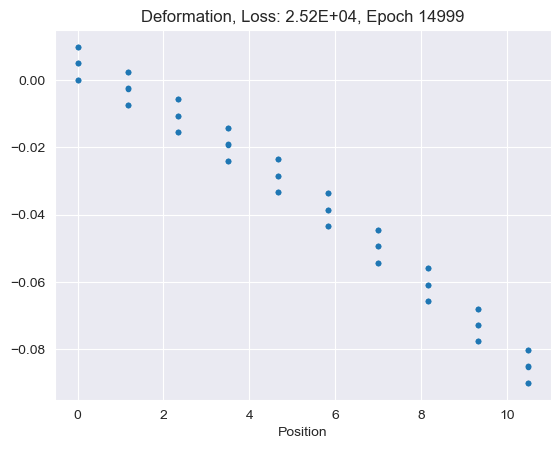

tensor([[[ 6.0147e+04, -2.3992e+01,  4.4117e+00],
         [-2.3992e+01, -3.1840e+01, -4.7156e+01],
         [ 4.4117e+00, -4.7156e+01, -9.4418e+00]],

        [[ 6.0153e+04, -2.3217e+01,  5.1619e+00],
         [-2.3217e+01, -3.1197e+01, -4.7504e+01],
         [ 5.1619e+00, -4.7504e+01, -7.2063e+00]],

        [[ 6.0158e+04, -2.2441e+01,  5.9132e+00],
         [-2.2441e+01, -3.0561e+01, -4.7851e+01],
         [ 5.9132e+00, -4.7851e+01, -4.9765e+00]],

        [[ 5.9979e+04,  4.0055e+00,  1.3050e+01],
         [ 4.0055e+00, -3.1469e+01,  3.1878e+00],
         [ 1.3050e+01,  3.1878e+00,  1.0279e+01]],

        [[ 5.9984e+04,  4.7234e+00,  1.3337e+01],
         [ 4.7234e+00, -3.1204e+01,  2.9383e+00],
         [ 1.3337e+01,  2.9383e+00,  1.2247e+01]],

        [[ 5.9988e+04,  5.4414e+00,  1.3625e+01],
         [ 5.4414e+00, -3.0943e+01,  2.6888e+00],
         [ 1.3625e+01,  2.6888e+00,  1.4212e+01]],

        [[ 5.9892e+04,  6.0319e+01, -2.1437e+00],
         [ 6.0319e+01,  5.6201e+01,  1

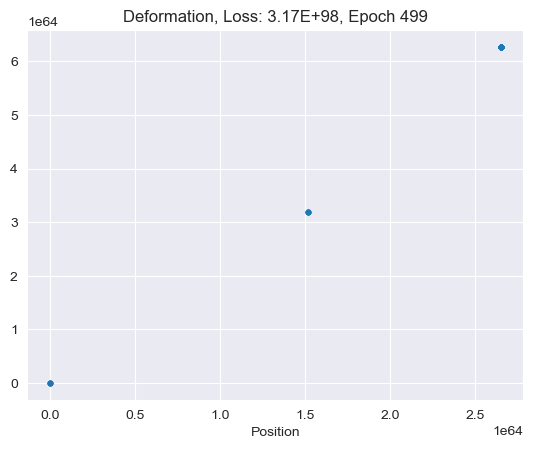

tensor([[[ 6.0147e+04, -2.3992e+01,  4.4117e+00],
         [-2.3992e+01, -3.1840e+01, -4.7156e+01],
         [ 4.4117e+00, -4.7156e+01, -9.4418e+00]],

        [[ 6.0153e+04, -2.3217e+01,  5.1619e+00],
         [-2.3217e+01, -3.1197e+01, -4.7504e+01],
         [ 5.1619e+00, -4.7504e+01, -7.2063e+00]],

        [[ 6.0158e+04, -2.2441e+01,  5.9132e+00],
         [-2.2441e+01, -3.0561e+01, -4.7851e+01],
         [ 5.9132e+00, -4.7851e+01, -4.9765e+00]],

        [[ 5.9979e+04,  4.0055e+00,  1.3050e+01],
         [ 4.0055e+00, -3.1469e+01,  3.1878e+00],
         [ 1.3050e+01,  3.1878e+00,  1.0279e+01]],

        [[ 5.9984e+04,  4.7234e+00,  1.3337e+01],
         [ 4.7234e+00, -3.1204e+01,  2.9383e+00],
         [ 1.3337e+01,  2.9383e+00,  1.2247e+01]],

        [[ 5.9988e+04,  5.4414e+00,  1.3625e+01],
         [ 5.4414e+00, -3.0943e+01,  2.6888e+00],
         [ 1.3625e+01,  2.6888e+00,  1.4212e+01]],

        [[ 5.9892e+04,  6.0319e+01, -2.1437e+00],
         [ 6.0319e+01,  5.6201e+01,  1

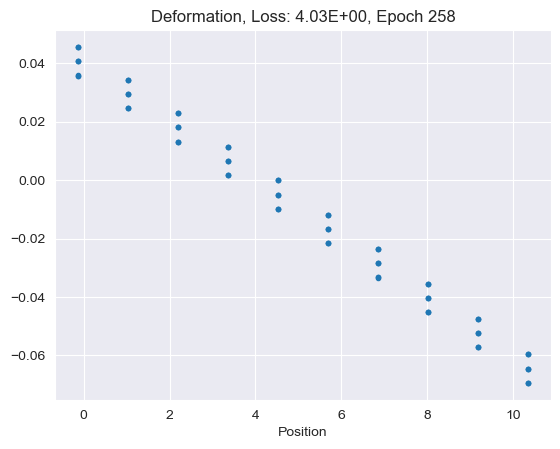

tensor([[[ 6.0147e+04, -2.3992e+01,  4.4117e+00],
         [-2.3992e+01, -3.1840e+01, -4.7156e+01],
         [ 4.4117e+00, -4.7156e+01, -9.4418e+00]],

        [[ 6.0153e+04, -2.3217e+01,  5.1619e+00],
         [-2.3217e+01, -3.1197e+01, -4.7504e+01],
         [ 5.1619e+00, -4.7504e+01, -7.2063e+00]],

        [[ 6.0158e+04, -2.2441e+01,  5.9132e+00],
         [-2.2441e+01, -3.0561e+01, -4.7851e+01],
         [ 5.9132e+00, -4.7851e+01, -4.9765e+00]],

        [[ 5.9979e+04,  4.0055e+00,  1.3050e+01],
         [ 4.0055e+00, -3.1469e+01,  3.1878e+00],
         [ 1.3050e+01,  3.1878e+00,  1.0279e+01]],

        [[ 5.9984e+04,  4.7234e+00,  1.3337e+01],
         [ 4.7234e+00, -3.1204e+01,  2.9383e+00],
         [ 1.3337e+01,  2.9383e+00,  1.2247e+01]],

        [[ 5.9988e+04,  5.4414e+00,  1.3625e+01],
         [ 5.4414e+00, -3.0943e+01,  2.6888e+00],
         [ 1.3625e+01,  2.6888e+00,  1.4212e+01]],

        [[ 5.9892e+04,  6.0319e+01, -2.1437e+00],
         [ 6.0319e+01,  5.6201e+01,  1

<Figure size 640x480 with 0 Axes>

In [14]:
model.load_state_dict(final_model_adam['model_state_dict'])
optim.load_state_dict(final_model_adam['optimizer_state_dict'])
epoch = final_model_adam['epoch']
loss = final_model_adam['loss']
model.eval()
plot_comp()
print(final_model_adam['p_sigma'])
print(final_model_adam['p_div'])

model.load_state_dict(final_model_LBGFS['model_state_dict'])
optim.load_state_dict(final_model_LBGFS['optimizer_state_dict'])
epoch = final_model_LBGFS['epoch']
loss = final_model_LBGFS['loss']
model.eval()
plot_comp()
print(final_model_adam['p_sigma'])
print(final_model_adam['p_div'])

model.load_state_dict(best_model['model_state_dict'])
optim.load_state_dict(best_model['optimizer_state_dict'])
epoch = best_model['epoch']
loss = best_model['loss']
model.eval()
plot_comp()
print(final_model_adam['p_sigma'])
print(final_model_adam['p_div'])

Saving Best Model

In [18]:
#PATH = f"3D_Isotropic_Beam_Model_{loss:.2E}_{epoch}.tar"
#torch.save(best_model, PATH)

Load Model

In [16]:
#PATH = "3D_Isotropic_Beam_Model_6.66E+00_999.tar"

#prevpoint = torch.load(PATH, map_location=device)
#model.load_state_dict(prevpoint['model_state_dict'])
#optim.load_state_dict(prevpoint['optimizer_state_dict'])
#epoch = prevpoint['epoch']
#loss = prevpoint['loss']
#model = model.to(device)
#model.eval()
#model.train()

Ploty and Dash Animaton

In [17]:
# obtaining plot range
x_range, x_int = 10, 10
y_range, y_int = 10e-3, 3
z_range, z_int = 10e-3, 3

plotting = grid(x_range,y_range,z_range,x_int,y_int,z_int).requires_grad_(True).to(device)
max_disp = 0

# obtaining plot data
model_pred = list()
for i in range(len(plotting)):
    #x,y,z,dx,dy,dz
    pred = model(plotting[i])
    model_pred.append([plotting[i][0].item(), plotting[i][1].item(), plotting[i][2].item(), pred[:,0].item(), pred[:,1].item(), pred[:,2].item()])
    if (np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2 + pred[:,2].item()**2) > max_disp): max_disp = np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2 + pred[:,2].item()**2)
model_pred = np.array(model_pred)

#setting limits
init = model_pred[:,0:3]
disp = model_pred[:,0:3] + model_pred[:,3:]
buffer = 0.4

init_scatter = go.Scatter3d(
    x=model_pred[:, 0],
    y=model_pred[:, 1],
    z=model_pred[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        colorscale='RdYlGn_r',
        color=np.zeros(len(model_pred[:, 0])),
        cmin=0,
        cmax=1,
        colorbar=dict(title='Normalized Displacement'),
    )
)

# Create init scatter
fig = go.Figure(data=[init_scatter])

# Create a Dash app
app = dash.Dash(__name__)

# Define the app layout
app.layout = html.Div([
    html.H1('Displacement Animation', style={'color': 'white'}),
    
    dcc.Graph(id='scatter-plot', figure=fig),
    
    dcc.Slider(
        id="frame-slider",
        min=0,
        max=100,
        step=0.1,
        value=0,
        marks={i: str(i) for i in range(0, 101, 10)},
        tooltip={"placement": "bottom"},
        updatemode='drag'
    )
])

# Callback to update the scatter plot
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('frame-slider', 'value')]
)

def update_scatter_plot(frame):
    # Update only the color data of the scatter plot
    fig.data[0].x = model_pred[:, 0] + frame * model_pred[:, 3] / 100
    fig.data[0].y =model_pred[:, 1] + frame * model_pred[:, 4] / 100
    fig.data[0].z =model_pred[:, 2] + frame * model_pred[:, 5] / 100
    fig.data[0].marker.color = np.sqrt(model_pred[:, 3]**2 + model_pred[:, 4]**2 + model_pred[:, 5]**2) * frame / max_disp / 100
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer]),
            yaxis=dict(range=[np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer]),
            zaxis=dict(range=[np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer]),
        ),
        autosize=False,
        width=800,
        height=600,
        uirevision='locked',
    )
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)